# EIT Continous Model - Solver

In [29]:
from module1_mesh import*
from module2_foward import*
from module3_inverse import*
from module4_auxiliar import*
import matplotlib.pyplot as plt
import pandas as pd
#from fenics import*

## Defining mesh

In [3]:
mesh_inverse, mesh_direct=MyMesh(r=1, n=8, n_vertex=321)
mesh_direct=refine(mesh_direct)

1070


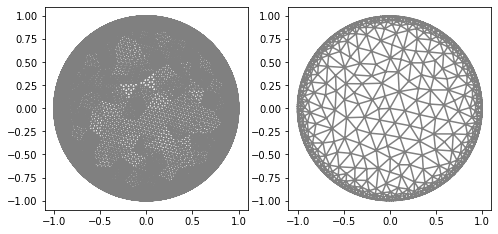

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plot(mesh_direct);
plt.subplot(1,2,2)
plot(mesh_inverse);

In [5]:
"Current"
n_g=6
I_all=current_method(n_g, value=1, method=1)

In [6]:
"Checking hyphotesis"
Verifyg(I_all, mesh_direct)
Verifyg(I_all, mesh_inverse)

Integral boundary: 1.8604909279851256e-16 0
Integral boundary: 1.6479873021779667e-17 1
Integral boundary: -7.91033905045424e-16 2
Integral boundary: 4.2760933682828295e-16 3
Integral boundary: 3.677613769070831e-16 4
Integral boundary: -6.271025365656158e-16 5
Integral boundary g(0)*g(1): 0.0
Integral boundary g(0)*g(2): 0.0
Integral boundary g(0)*g(3): 0.0
Integral boundary g(0)*g(4): 0.0
Integral boundary g(0)*g(5): 0.0
Integral boundary g(1)*g(2): 0.0
Integral boundary g(1)*g(3): 0.0
Integral boundary g(1)*g(4): 0.0
Integral boundary g(1)*g(5): 0.0
Integral boundary g(2)*g(3): 0.0
Integral boundary g(2)*g(4): 0.0
Integral boundary g(2)*g(5): 0.0
Integral boundary g(3)*g(4): 0.0
Integral boundary g(3)*g(5): 0.0
Integral boundary g(4)*g(5): 0.0
Integral boundary: 2.3418766925686896e-16 0
Integral boundary: 7.979727989493313e-17 1
Integral boundary: -6.331740687315346e-16 2
Integral boundary: 3.3480163086352377e-16 3
Integral boundary: 2.5153490401663703e-16 4
Integral boundary: -5.49

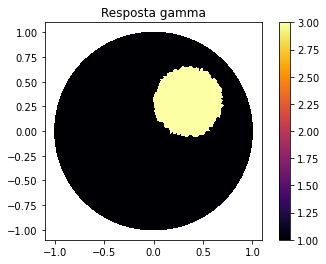

In [7]:
"Defining gamma"
ValuesCells0=GammaCircle(mesh_direct,3,1,0.35, 0.35, 0.30); #malha, cond_interna, cond_externa, raio.
gamma0=CellFunction(mesh_direct, values=ValuesCells0);#Pega o vetor e transforma em uma função

"Plot"
V_DG=FiniteElement('DG',mesh_inverse.ufl_cell(),0)
gamma_direct=plot_figure(mesh_direct, V_DG, gamma0, name="Resposta gamma");

In [8]:
"FowardProblem"
VD=FiniteElement('CG',mesh_direct.ufl_cell(),1) 
FowardObject=FowardProblem(mesh_direct)
list_u0=FowardObject.solve_foward(VD, gamma0, I_all)

u0_boundary=FowardObject.boundary_array(mesh_inverse) #Boundary data in the mesh_inverse

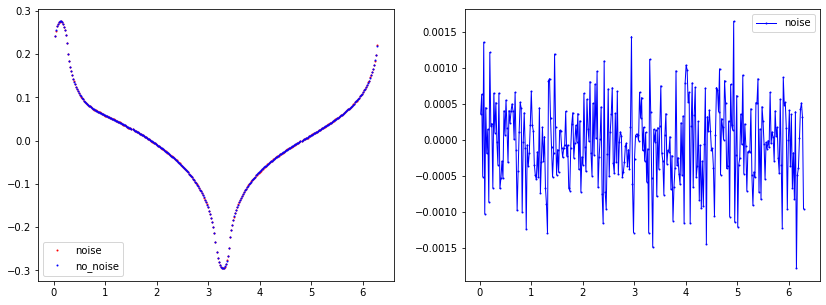

In [9]:
"Noise Parameters"
noise_level=0.005
noise_type='uniform'
seed=1
u0_boundary=FowardObject.add_noise(noise_level, noise_type, seed, mesh_inverse)
end=len(u0_boundary)
    
index=0 #Index solution plot
if noise_level>1E-5:
    u0_boundary_c=FowardObject.boundary_array(mesh_inverse, concatenate=False)
    u_dados_noise=u0_boundary[0:int(end/n_g)]
    data_u0=plot_boundary(mesh_inverse, data=u0_boundary_c[index], name='boundary u0_0', line=0, plot=False)
    data_u0_noise=plot_boundary(mesh_inverse, data=u_dados_noise, name='boundary u0_0', line=0, plot=False)
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1,2,1)
    plt.plot(data_u0_noise[:,0], data_u0_noise[:,1], linewidth=0,  marker='.', markersize=2, label="noise", color='red');
    plt.plot(data_u0[:,0], data_u0[:,1], linewidth=0,  marker='.', markersize=2, label="no_noise", color="blue");
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(data_u0[:,0], data_u0[:,1]-data_u0_noise[:,1], linewidth=1,  marker='.', markersize=2, label="noise", color="blue");
    plt.legend()
    
    plt.show()
    

### Inverse Solver

In [17]:
"Object"
VI=FiniteElement('CG',mesh_inverse.ufl_cell(),1) 
InverseObject=InverseProblem(mesh_inverse, VI, u0_boundary, I_all)

"Solver Parameters"
InverseObject.set_solverconfig(step_limit=100)
InverseObject.set_NewtonParameters(mu_i=0.97, mumax=0.999, nu=0.99, R=0.999)
#InverseObject.set_InnerParameters(inner_method='Landweber', land_a=20)
InverseObject.set_InnerParameters(inner_method='ME', ME_reg=5E-3)
#InverseObject.set_InnerParameters(inner_method='CG')
#InverseObject.set_InnerParameters(inner_method='LM', LM_c0=0.95, LM_q=0.05)
#InverseObject.set_InnerParameters(inner_method='Tikhonov', Tik_c0=0.95, Tik_q=0.05)

"Noise Parameters"
tau=1.2
InverseObject.set_NoiseParameters(tau=tau, noise_level=0.005)
print(f"Discrepance stop {tau*noise_level*100}% residue")

"Extra Parameters"
InverseObject.set_answer(gamma0, mesh_direct)
InverseObject.weight_value=False
#MyCellsgamma_k=np.ones(mesh_inverse.num_cells())*2.0
#InverseObject.set_firstguess(MyCellsgamma_k)

Discrepance stop 0.6% residue


In [18]:
InverseObject.solve_inverse()

Error (%)= 52.64400745794586 Residuo (%)= 22.223768199837497  passo: 0 Inner step:  0
mu_n 0.97
0.15423676646366735 0.15101915329648521 1 0.0944792969696922
0.1527971487937241 0.15101915329648521 2 0.09460384866601594
0.15137087045669162 0.15101915329648521 3 0.09473055896095911
0.14995780731923106 0.15101915329648521 4 0.09485947014750706
Error (%)= 52.34809066068612 Residuo (%)= 21.412334779698703  passo: 1 Inner step:  4
mu_n 0.97
0.14860284839613522 0.1455051474373561 1 0.0983491202048385
0.1472134048778179 0.1455051474373561 2 0.09848864873208411
0.14583685474012115 0.1455051474373561 3 0.09863062370116207
0.1444730777658983 0.1455051474373561 4 0.09877509386871451
Error (%)= 52.060220672991434 Residuo (%)= 20.629022477727823  passo: 2 Inner step:  4
mu_n 0.96903
0.143164313923228 0.1400420532839904 1 0.10232929689139342
0.14182343703122652 0.1400420532839904 2 0.1024855565499679
0.14049502040671247 0.1400420532839904 3 0.10264458952528051
0.13917894764539274 0.1400420532839904 4 

0.06319071325536488 0.06375223900755485 5 0.24447814416761326
Error (%)= 47.37673806106585 Residuo (%)= 9.022930894095266  passo: 23 Inner step:  5
mu_n 0.9678101449043583
0.06259740605426194 0.061175904543188386 1 0.25305694077666435
0.0619898948076522 0.061175904543188386 2 0.2552040742770638
0.061388054347946606 0.061175904543188386 3 0.257413869049651
0.060791827132934725 0.061175904543188386 4 0.2596887133699877
Error (%)= 47.210150857441086 Residuo (%)= 8.67939336830112  passo: 24 Inner step:  4
mu_n 0.9658754924246946
0.06021282698374505 0.05872906906868887 1 0.2675438105899037
0.059627187068824215 0.05872906906868887 2 0.2700255604276971
0.059046998581224384 0.05872906906868887 3 0.27258260870619183
0.058472205495519514 0.05872906906868887 4 0.27521794345985234
Error (%)= 47.04527125232317 Residuo (%)= 8.348206761024587  passo: 25 Inner step:  4
mu_n 0.9639447073153377
0.05791393563383005 0.056375176946630134 1 0.28373199147182593
0.057349334850583515 0.056375176946630134 2 0.2

0.024470023425168286 0.023947144694743617 2 2.7553028582388044
0.02419835351686026 0.023947144694743617 3 2.816431636354258
0.023930161353037403 0.023947144694743617 4 2.880431605043299
Error (%)= 42.660695207525286 Residuo (%)= 3.4168055568501186  passo: 46 Inner step:  4
mu_n 0.9560128454255005
0.023671581019214693 0.02288371817566123 1 3.020184489295389
0.02341000111678753 0.02288371817566123 2 3.0919430511505155
0.023151831560603832 0.02288371817566123 3 3.167505231845112
0.022897020156953718 0.02288371817566123 4 3.2471473178548154
0.02264551325179651 0.02288371817566123 5 3.3311677512728695
Error (%)= 42.32662462878169 Residuo (%)= 3.2338244207228812  passo: 47 Inner step:  5
mu_n 0.96384546606406
0.02240613320904815 0.021835666030673485 1 3.522656712143332
0.022160788966626734 0.021835666030673485 2 3.618975584387743
0.021918632945561234 0.021835666030673485 3 3.7209384870024547
0.02167959278815156 0.021835666030673485 4 3.828959940553791
Error (%)= 42.051415345709316 Residuo (%

0.008333792465004795 0.00805482580562938 1 54.32490556103814
0.008279177202551516 0.00805482580562938 2 28.47683064389728
0.008210524833472175 0.00805482580562938 3 59.765677158816224
0.008157413136007088 0.00805482580562938 4 27.322683294155777
0.008087263062645414 0.00805482580562938 5 64.94190141356336
0.008035597363120227 0.00805482580562938 6 26.61656863692194
Error (%)= 34.321669123103696 Residuo (%)= 1.1469513963916402  passo: 68 Inner step:  6
mu_n 0.9578635097412035
0.00796558613416009 0.007696463986545806 1 67.62789716009773
0.007914950537254902 0.007696463986545806 2 25.906280640582224
0.007843832166445288 0.007696463986545806 3 72.96624313362503
0.0077946361258469715 0.007696463986545806 4 25.642062757187436
0.007725236952452864 0.007696463986545806 5 76.10591460927195
0.007676980346217115 0.007696463986545806 6 24.737914528520687
Error (%)= 34.04449761842135 Residuo (%)= 1.0957208445875386  passo: 69 Inner step:  6
mu_n 0.9569056462314622
0.00760483524077574 0.007345335530

0.004857449958124991 0.004778894886704452 10 78.96117462673949
0.004820155091521244 0.004778894886704452 11 8.674579363573255
0.004806802395442745 0.004778894886704452 12 29.418562423023086
0.004836699850284788 0.004778894886704452 13 74.02292914945949
0.004800529977968804 0.004778894886704452 14 9.469226964784896
0.004796148185584898 0.004778894886704452 15 37.617659008337604
0.004788358211938706 0.004778894886704452 16 34.37176872855741
0.0047922612819077 0.004778894886704452 17 45.483787084174466
0.0047708582228497675 0.004778894886704452 18 21.796080481854943
Error (%)= 31.742505854347957 Residuo (%)= 0.6809774228355417  passo: 80 Inner step:  18
mu_n 0.9698762267732263
0.004894369732452794 0.00462691611481349 1 288.0832569048029
0.004849742575622529 0.00462691611481349 2 2.72245225745225
0.004806704059857201 0.00462691611481349 3 3.674727432133604
0.0047664154174509275 0.00462691611481349 4 5.614691599968084
0.0047332433577214365 0.00462691611481349 5 11.313246944148785
0.00475904

0.0041832472116756685 0.00409406320801862 14 14.484148517045954
0.004402015313201403 0.00409406320801862 15 287.53962451937593
0.004360983588416858 0.00409406320801862 16 1.7419957764855403
0.00432073520855163 0.00409406320801862 17 2.0894568916980836
0.004281458565159878 0.00409406320801862 18 2.6153946811905353
0.004243535109224256 0.00409406320801862 19 3.4979424591166195
0.00420790671846849 0.00409406320801862 20 5.2544526570119015
0.004177968512576956 0.00409406320801862 21 10.159480185014612
0.004189786038879886 0.00409406320801862 22 49.62716873109981
0.004167882042440158 0.00409406320801862 23 17.3325522106926
0.004507099381093142 0.00409406320801862 24 1642.2913115439167
0.004464108775934081 0.00409406320801862 25 1.0747231278823033
0.004421653863872202 0.00409406320801862 26 1.1902907861075096
0.004379760323871957 0.00409406320801862 27 1.3362166075410504
0.0043384674212546 0.00409406320801862 28 1.526023825921059
0.004297837413506023 0.00409406320801862 29 1.7825361138280709

In [20]:
"Getting the result"
gamma_k=InverseObject.gamma_k

"Getting data_summary"
innerstep_vec=InverseObject.innerstep_vec
res_vec=InverseObject.res_vec
mun_vec=InverseObject.mun_vec
error_vec=InverseObject.error_vec

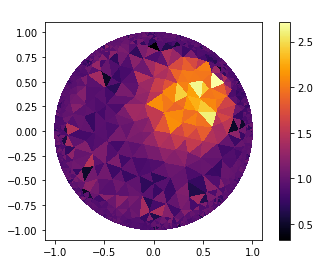

In [21]:
"Plot result"
V_DG=FiniteElement('DG',mesh_inverse.ufl_cell(),0)
gamma_k=plot_figure(mesh_inverse, V_DG, gamma_k, name=" ");

jet


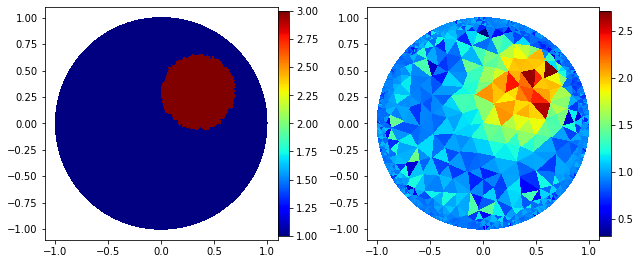

In [23]:
"Fancy plot"
cmap=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
cmap=cmap[126]#51 63 90 94 126 164 111
#cmap='inferno'
#print(cmap)
fig=plt.figure(figsize=(9, 9))
plt.subplot(1,2,1);
p=plot(gamma_direct);
p.set_cmap(cmap)
plt.colorbar(p,fraction=0.046, pad=0.0);

plt.subplot(1,2,2);
p=plot(gamma_k);
p.set_cmap(cmap);
plt.colorbar(p,fraction=0.046, pad=0.0);
fig.tight_layout()
print(cmap)

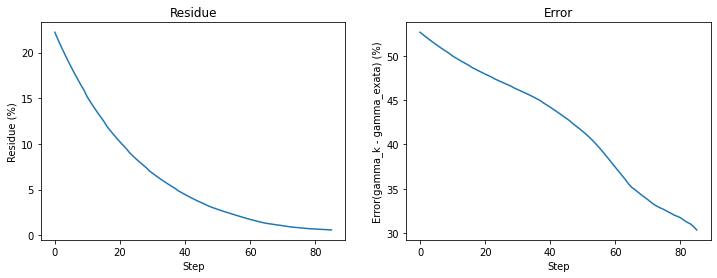

In [25]:
plt.figure(figsize=(12, 4));

"Subplot 1"
plt.subplot(1,2,1)
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot(range(0,len(res_vec)), res_vec);

"Subplot 2"
plt.subplot(1,2,2)
plt.ylabel('Error(gamma_k - gamma_exata) (%)');
plt.xlabel('Step');
plt.title('Error');
plt.plot(range(0,len(error_vec)), error_vec);

In [34]:
summary_data=np.vstack((error_vec, res_vec, innerstep_vec, mun_vec))
data=pd.DataFrame(summary_data.T)
experiments=["Error (%)", "Residue (%) ", "Inner Step", "mu_n"]
data.columns = experiments
data

,Error (%),Residue (%),Inner Step,mu_n
0,52.644007,22.223768,0.0,0.000000
1,52.348091,21.412335,4.0,0.970000
2,52.060221,20.629022,4.0,0.970000
3,51.780237,19.872940,4.0,0.969030
4,51.507966,19.143220,4.0,0.968061
...,...,...,...,...
81,31.486883,0.657772,24.0,0.969876
82,31.240467,0.639926,17.0,0.976430
83,31.063568,0.621018,8.0,0.974478
84,30.757833,0.602113,52.0,0.972530
